In [1]:
!pip install gdown

In [2]:
!gdown https://drive.google.com/uc?id=1NNpbV5N9MDj4vn-k5ANT1nqY9-z_vGRa
!gdown https://drive.google.com/uc?id=18iBU4VFLg8zCrh5iZ66mbLJ51iJaWs4Z

Downloading...
From: https://drive.google.com/uc?id=1NNpbV5N9MDj4vn-k5ANT1nqY9-z_vGRa
To: /content/test.csv
100% 331k/331k [00:00<00:00, 47.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=18iBU4VFLg8zCrh5iZ66mbLJ51iJaWs4Z
To: /content/train.csv
100% 974k/974k [00:00<00:00, 64.8MB/s]


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#some libraries cause this future warnings when the newer versions will be released. To prevent showing them, this code is used.

Original kitapyurdu.com dataset contains around 125K reviews and ratings. However, training the model with this amount takes a lot of time. Therefore, we previously prepare the data as highly balanced and smaller size. The reason for that **handling imbalanced data is advanced topic, if you are interestedn in this, [you can follow this paper.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907)** The script includes data preparation steps will be shared with participants after the workshop.

In [22]:
import pandas as pd
df_train = pd.read_csv(r"train.csv",index_col=[0])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print()
print(df_train["label"].value_counts())
df_test = pd.read_csv(r"test.csv",index_col=[0])
# Report the number of sentences.
print()
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
print()
print(df_test["label"].value_counts())

Number of training sentences: 7,050


2    2350
1    2350
0    2350
Name: label, dtype: int64

Number of test sentences: 2,400


1    800
2    800
0    800
Name: label, dtype: int64


**Classes:**



0.   Negative
1.   Neutral
2.   Positive


In [23]:
df_train.head()

,review,label
0,Kitabı bugün 3. defa kaldığım yerden devam etm...,0
1,Stefan zweig’in en sevdiğim özelliği basit cüm...,0
2,Her yerde karşıma çıktığı için almıştım .Norma...,0
3,kitapların damağımızda bıraktığı tadı paylaşab...,0
4,Çocukken okumuş ve feci sıkılarak yarım bırakm...,0


In [24]:
df_test.head()

,review,label
0,Şunu söylemekte fayda görüyorum yazar ile bizi...,0
1,çok sarmadı beni bitirmek için seriyi başladım...,0
2,köşe yazısı gibi zaman israfı keşke bir kez da...,0
3,Kişiler cok oldugu için kafanı karıştırıyor ak...,0
4,BEKLENTİMİ KARŞILAYAN BİR KİTAP OLMADI..,0


## TEXT PREPROCESSING

In [25]:
 df_train.review[0]

'Kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım. Ancak yine daha iyi anlamak için baştan başladım(3. defa). Hatta kararsızım okuyup okumamakta, çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni. Hadi bakalım inşallah bu sefer bitireceğim kitabı. Son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum.'

In [26]:
import numpy as np 
import nltk
import string as s
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
def preprocess(text,remove_stop_punc=False):
  text=text.lower()
  
  text=text.replace("\n"," ")
  #removing URL
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)

  #Replace &amp, &lt, &gt with &,<,> respectively
  text=text.replace(r'&amp;?',r'and')
  text=text.replace(r'&lt;',r'<')
  text=text.replace(r'&gt;',r'>')

  #remove hashtags
  text=re.sub(r"#[A-Za-z0-9]+","",text)   
  #remove \
  text=re.sub(r"\\ "," ",text)
 
  #remove punctuations and stop words
  stop_words=stopwords.words('turkish')
  tokens=nltk.word_tokenize(text)
  if remove_stop_punc:
    tokens_new=[i for i in tokens if not i in stop_words and i.isalpha()] #isalpha() method returns True if all the characters are alphabet letters
  else:
    tokens_new=tokens
  
  #remove excess whitespace
  text= ' '.join(tokens_new)
  return text

df_train["review"]=df_train["review"].apply(preprocess,remove_stop_punc=False)
df_test["review"]=df_test["review"].apply(preprocess,remove_stop_punc=False)

#Remove reviews which have no word in them
df_train["Text_length"] = [len(text.split(' ')) for text in df_train.review]
df_train = df_train[df_train["Text_length"]>1]

#Remove reviews which have no word in them
df_test["Text_length"] = [len(text.split(' ')) for text in df_test.review]
df_test = df_test[df_test["Text_length"]>1]


In [28]:
df_train.review[0]

'kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım . ancak yine daha iyi anlamak için baştan başladım ( 3. defa ) . hatta kararsızım okuyup okumamakta , çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni . hadi bakalım inşallah bu sefer bitireceğim kitabı . son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum .'

##### **BEFORE PREPROCESSING:**

> Kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım. Ancak yine daha iyi anlamak için baştan başladım(3. defa). Hatta kararsızım okuyup okumamakta, çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni. Hadi bakalım inşallah bu sefer bitireceğim kitabı. Son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum.



# FEATURE EXTRACTION WITH TF-IDF AND MODELLING WITH MULTINOMIAL NB

In [29]:
texts = df_train.review
labels = df_train.label

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels, random_state=42, test_size=0.2)

test_x=df_test.review
test_y=df_test.label

In [30]:
stop_words=stopwords.words('turkish')
stop_words

['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [35]:
stop_words=stopwords.words('turkish')

tfidf=TfidfVectorizer(max_df=0.7,min_df=5) #actually, we already discard the stop words in preprocessing

train_1=tfidf.fit_transform(train_x)

valid_1=tfidf.transform(valid_x)

test_1=tfidf.transform(test_x)


print("No. of features extracted")
print(len(tfidf.get_feature_names()))
print(tfidf.get_feature_names()[:20])

train_arr=train_1.toarray()
valid_arr=valid_1.toarray()
test_arr=test_1.toarray()

No. of features extracted
2327
['10', '100', '15', '1984', '20', '30', '40', '50', '60', '70', 'abartı', 'abartılacak', 'abartılan', 'abartıldığı', 'abartıldığını', 'abartılmış', 'abartılı', 'abartılıyor', 'acaba', 'acayip']


# MODELLING

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work. https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [36]:
nb=MultinomialNB()
nb.fit(train_arr,train_y)
pred=nb.predict(valid_arr)

from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of TF-IDF and Multinomial NB is:",accuracy_score(valid_y, pred))

print(classification_report(valid_y, pred))


Accuracy of TF-IDF and Multinomial NB is: 0.5971631205673759
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       490
           1       0.49      0.42      0.45       469
           2       0.66      0.74      0.70       451

    accuracy                           0.60      1410
   macro avg       0.59      0.60      0.59      1410
weighted avg       0.59      0.60      0.59      1410



#TESTING THE MODEL

In [37]:
test_pred=nb.predict(test_arr)

from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of TF-IDF and Multinomial NB is:",accuracy_score(test_y, test_pred))

print(classification_report(test_y, test_pred))


Accuracy of TF-IDF and Multinomial NB is: 0.5854166666666667
              precision    recall  f1-score   support

           0       0.59      0.58      0.59       800
           1       0.48      0.41      0.44       800
           2       0.67      0.76      0.71       800

    accuracy                           0.59      2400
   macro avg       0.58      0.59      0.58      2400
weighted avg       0.58      0.59      0.58      2400



<Figure size 432x288 with 0 Axes>

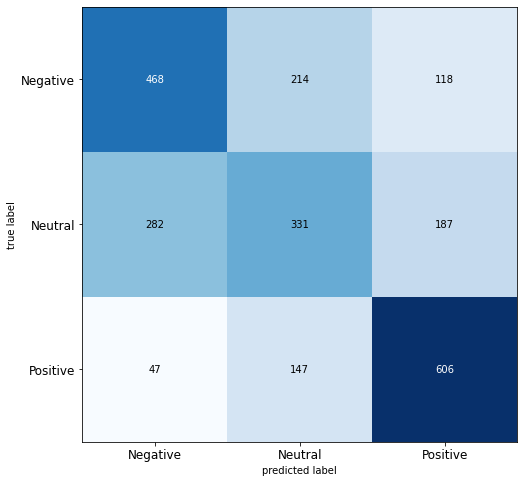

In [38]:
cm  = confusion_matrix(test_y, test_pred)
labels = ['Negative', 'Neutral', 'Positive']
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(8,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), labels, fontsize=12)
plt.yticks(range(3), labels, fontsize=12)
plt.show()